Описание задачи
Дан набор 3D примитивов. Необходимо решить задачу классификации объектов с помощью нейронной сети, представленных в форме облака точек.

Набор данных разбит на три части: train, test, valid.

Для этого нужно:

Используя набор данных из категории train обучить модель классификации.
Оценить качество её работы на объектах из категории test. Для этого воспользоваться classification_report из scikit-learn. Провести финальную оценку на valid. Написать краткий отчёт по результатам оценки качества модели: насколько хорошо/плохо работает модель, насколько она обобщается на данные из valid набора, что можно сделать для улучшения результатов.
Задачу можно решать в Google Colab, если нет возможности использовать GPU.

In [ ]:
pip install pyntcloud

     |████████████████████████████████| 346 kB 8.4 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import time
import os
import pyntcloud
import matplotlib.pyplot as plt

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('There are %d GPU(s) available.' % torch.cuda.device_count())
if torch.cuda.is_available(): 
  print('You got a GPU:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
You got a GPU: Tesla P100-PCIE-16GB


# Модель реализация PointNet:

Создаем блок T-net который кодирует наше облако точек в матрицы для Multi-Scale Grouping

In [ ]:
class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, input):
        # input.shape == (bs,3,n)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix

Блок приобразования облака точек в матрицы для Multi-Scale Grouping 

In [ ]:
class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.lower_feature_transform = Tnet(k=16)
        self.feature_transform = Tnet(k=64)
        
        self.conv1 = nn.Conv1d(3,16,1)
        self.conv2 = nn.Conv1d(16,64,1)
        self.conv3 = nn.Conv1d(64,128,1)
        self.conv4 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(16)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(1024)

    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix16x16 = self.lower_feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix16x16).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn3(self.conv3(xb)))
        xb = self.bn4(self.conv4(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)

        return output, matrix3x3, matrix16x16, matrix64x64

Сборка модели блок Transform, внутри него T-Net. После них полносвязные слои с нормализацией по батчу и слоем Dropout для регуляризации. Из модели получаем вероятность класса через logsoftmax,  и длполнительно матрицы кодирования для оптимизации в функции потерь.

In [ ]:
class PointNet(nn.Module):
    def __init__(self, classes = 6):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.5)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix16x16, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.dropout(self.fc1(xb))))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix16x16, matrix64x64

Функция потерь для pointnet, это функция NLLLoss с регуляризацией по матрицам кодирования.

In [ ]:
def pointnetloss(outputs, labels, m3x3, m16x16, m64x64, alpha = 0.0005):
    
    criterion = torch.nn.NLLLoss().to(device)
    bs=outputs.size(0)   
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1).to(device)
    id16x16 = torch.eye(16, requires_grad=True).repeat(bs,1,1).to(device)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1).to(device)
    
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff16x16 = id16x16-torch.bmm(m16x16,m16x16.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))

    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)+torch.norm(diff16x16)) / float(bs)

Функция обучения модели, записываем историю для того что бы построить кривые обучения.

In [ ]:
def train(model, train_loader, val_loader=None,  n_epochs=1):
    
    start_time = time.time()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    history = dict(train=[], val=[], val_acc=[])

    for epoch in range(1, n_epochs + 1): 
        model = model.train()
        train_losses = []
        
        for data in train_loader:
          optimizer.zero_grad()
          xyz, labels = data
          xyz = xyz.to(device)
          labels = labels.to(device)
          outputs, m3x3, m16x16, m64x64 = model(xyz)
          loss = pointnetloss(outputs, labels, m3x3, m16x16, m64x64)
          loss.backward()
          optimizer.step()
          train_losses.append(loss.item())
    
        val_losses = []
        val_accs = []
        correct = total = 0
        if val_loader:
          model = model.eval()
          with torch.no_grad():
            
            for data in val_loader:
              xyz, labels = data
              xyz = xyz.to(device)
              labels = labels.to(device)
              outputs, m3x3, m16x16, m64x64 = model(xyz)
              loss = pointnetloss(outputs, labels, m3x3, m16x16, m64x64)
              total += labels.size(0)
              _, predicted = torch.max(outputs.data, 1)
              correct += (predicted == labels).sum().item()
            val_accs.append(100. * correct / total)
            val_losses.append(loss.item())
          
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        val_acc =np.mean(val_accs)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss} Valid accuracy: {val_acc}', time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time)))
 
    # save the model
    torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Test 3dML/Task3/pointnet.pth")
    return model.eval(), history

# Данные создание Dataloader

Создаем словарь классов, сможем его вводить в датасеты что бы не возникло путаницы при проверке.

In [ ]:
class_dict={}
lables=os.listdir(path='/content/drive/MyDrive/Colab Notebooks/Test 3dML/Task3/dataset-v2/train')
for lable in lables:
  class_dict[lable]=lables.index(lable)

Создаем датасет из файлов obj метка класса название папки:

In [ ]:
class PointCloudData(torch.utils.data.Dataset):
    def __init__(self, data_dir, class_dict, n_numb=10000):
        self.data_dir=data_dir
        self.samples = []
        self.lables=os.listdir(path=data_dir)
        self.n_numb=n_numb
        self.class_dict=class_dict

        for lable in  self.lables:
          path_2_file=os.path.join(data_dir,lable)
          for file in os.listdir(path=path_2_file):
            self.samples.append((file,lable))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        
        data_path = os.path.join(self.data_dir, self.samples[idx][1],self.samples[idx][0])
        pc=pyntcloud.PyntCloud.from_file(data_path)       
        pc=pc.get_sample("mesh_random", n=self.n_numb, rgb=False, normals=True, as_PyntCloud=True)
        xyz = pc.points[['x','y','z']].values

       
        return (torch.swapdims(torch.tensor(xyz, dtype=torch.float32),0,1), self.class_dict[self.samples[idx][1]])

Определяем Train, Test и Valid DataLoader для подачи данных в модель батчами.

In [ ]:
trainloader = torch.utils.data.DataLoader(PointCloudData(data_dir='/content/drive/MyDrive/Colab Notebooks/Test 3dML/Task3/dataset-v2/train', class_dict=class_dict), 
                                          batch_size=16, shuffle=True, num_workers=2)

In [ ]:
testloader = torch.utils.data.DataLoader(PointCloudData(data_dir='/content/drive/MyDrive/Colab Notebooks/Test 3dML/Task3/dataset-v2/test', class_dict=class_dict), 
                                          batch_size=16, shuffle=True, num_workers=2)

In [ ]:
validloader = torch.utils.data.DataLoader(PointCloudData(data_dir='/content/drive/MyDrive/Colab Notebooks/Test 3dML/Task3/dataset-v2/valid', class_dict=class_dict), 
                                          batch_size=16, shuffle=True, num_workers=2)

# Обучение и оценка процесса обучения

In [ ]:
point_net_model=PointNet()
point_net_model = point_net_model.to(device)
#point_net_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Test 3dML/Task3/pointnet.pth'))


In [ ]:
point_net_model, history = train(point_net_model, trainloader, testloader, n_epochs=1500)

Epoch 1: train loss 1.6512550926208496 val loss 1.777560830116272 Valid accuracy: 26.5 00:00:32
Epoch 2: train loss 1.4725602515538534 val loss 1.715743064880371 Valid accuracy: 27.833333333333332 00:01:04
Epoch 3: train loss 1.4063126293818156 val loss 1.8045216798782349 Valid accuracy: 24.333333333333332 00:01:37
Epoch 4: train loss 1.3672363996505736 val loss 1.758952260017395 Valid accuracy: 29.166666666666668 00:02:09
Epoch 5: train loss 1.3361603037516276 val loss 1.461746335029602 Valid accuracy: 27.666666666666668 00:02:41
Epoch 6: train loss 1.3129943402608235 val loss 1.663030743598938 Valid accuracy: 30.666666666666668 00:03:13
Epoch 7: train loss 1.2820537892977397 val loss 1.247894048690796 Valid accuracy: 31.166666666666668 00:03:46
Epoch 8: train loss 1.2535997748374939 val loss 1.472509503364563 Valid accuracy: 29.833333333333332 00:04:18
Epoch 9: train loss 1.2576570439338683 val loss 1.8277182579040527 Valid accuracy: 36.166666666666664 00:04:50
Epoch 10: train loss 1

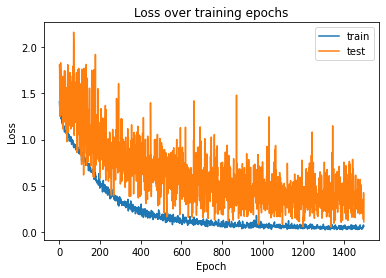

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'][2:])
ax.plot(history['val'][2:])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

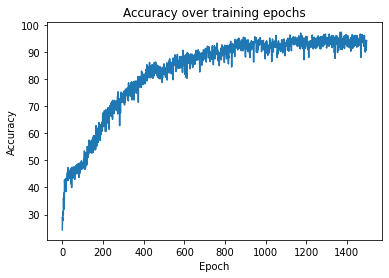

In [ ]:
ax = plt.figure().gca()

ax.plot(history['val_acc'][2:])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy over training epochs')
plt.show();

# Оценка качества работы модели:

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
model = PointNet()
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Test 3dML/Task3/pointnet.pth'))

<All keys matched successfully>

Оценка на объектах из категории test:

In [ ]:
y_test=[]
y_pred_test=[]
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
  for i in PointCloudData(data_dir='/content/drive/MyDrive/Colab Notebooks/Test 3dML/Task3/dataset-v2/test', class_dict=class_dict):
    xyz, labels = i
    y_test.append(labels)
    y_pred, _, _, _ = model(torch.tensor(np.expand_dims(xyz.numpy(),0)))
    y_pred_test.append(np.argmax(y_pred.numpy()))

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=class_dict.keys()))

              precision    recall  f1-score   support

        cube       0.89      0.93      0.91       100
    cylinder       0.97      0.94      0.95       100
       plane       0.86      0.95      0.90       100
        cone       1.00      0.93      0.96       100
   uv_sphere       0.96      1.00      0.98       100
       torus       1.00      0.90      0.95       100

    accuracy                           0.94       600
   macro avg       0.95      0.94      0.94       600
weighted avg       0.95      0.94      0.94       600



Проверка valid наборt:

In [ ]:
y_val=[]
y_pred_val=[]
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
  for i in PointCloudData(data_dir='/content/drive/MyDrive/Colab Notebooks/Test 3dML/Task3/dataset-v2/valid', class_dict=class_dict):
    xyz, labels = i
    y_val.append(labels)
    y_pred, _, _, _ = model(torch.tensor(np.expand_dims(xyz.numpy(),0)))
    y_pred_val.append(np.argmax(y_pred.numpy()))

In [ ]:
print(classification_report(y_val, y_pred_val, target_names=class_dict.keys()))

              precision    recall  f1-score   support

        cube       0.85      1.00      0.92        50
    cylinder       1.00      0.84      0.91        50
       plane       0.89      0.96      0.92        50
        cone       0.98      1.00      0.99        50
   uv_sphere       1.00      1.00      1.00        50
       torus       1.00      0.88      0.94        50

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



Точность модели 94% при базовой точности случайного распределения 15% для 6 классов. Модель работает довольно хорошо если добавить в функцию тренеровки вывод наилучшей модели по accuracy то думаю точность будет около 97%. 

По значениям precision можено сказать что модель часто относит к кубу то что кубом не является. Определение сферы самое точное, я думаю что это связано с количеством и размером граней куб и плоскость полностью состоят из граней и по этой причине определяются хуже, шар и тор в идеальном состоянии граней не имеют и по этому определяются более однозначно, в пользу этой теории так же можно представить среднии случаи конус определяется лучше целиндра.

Повысить точность модели, как мне кажется можно улучшив предобработку данных,напремер если семплинг производить не по объему а по поверхностям фигуры то точность должна вырасти, а еще думаю хорошим способом было бы добавлять точки только на ребра(по замкнутым концентрическим линиям на поверхности в случае гладких фигур) в этом случае мы бы получили каркас который, скорее всего определялся бы еще лучше.

Дополнительно в ходе эксперементоы было выявлено что модель очень чувствительна к коэффиценту регуляризации(alfa в функции потерь) и к количеству подаваемых в модель точек. При неподходящих гиперпараметрах точность модели не привыщала 50% что лучше базового случая, но не достаточно точно.